# Fraud Detection Example

## Context

This notebook is based on Kaggle's dataset Fraud Detection Example used in Alura's course [Modelos Preditivos em Dados: Detecção de Fraude (Data Preditive Models: Fraud Detection)](https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude) By Sthefanie Monica. Here you will find exploratory data analysis and its conclusions and several classification models such as decision trees, random forest, and XGBoost. 

[Here](https://www.kaggle.com/datasets/gopalmahadevan/fraud-detection-example) you can find the dataset on Kaggle.

All the code was written in Python 3, using Jupyter Notebooks.

In [1]:
# Importing libraries

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

from utils.plotting import plot_confusion_matrix, plot_roc_auc
from utils.score import print_scores

## Data cleaning

In [2]:
# Loading dataset

df = pd.read_csv('c:\\fraud_dataset_example.csv')

In [3]:
# Displaying the first five rows

df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [4]:
# Displaying df's shape

df.shape

(101613, 11)

In [5]:
# Checking data types

df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [6]:
# Checking the dataset's columns

df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

There is a mispelled column name: "oldbalanceOrg", that should be "oldbalanceOrig". Let's change it.

In [7]:
# Creating a dict to change column name

columns = {"oldbalanceOrg": "oldbalanceOrig"}

# Renaming the column

df.rename(columns, axis=1, inplace=True)

In [8]:
# Checking again dataset's columns to confirm that the change was made

df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [9]:
# Checking null values

df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no null values.

## Feature engineering

Let's create two new columns, one with the amount percentage of the origin old balances and other for to check if the origin and the destination names are the same.

In [10]:
# Creating new features

df["percAmountOldOrig"] = df["amount"]/df["oldbalanceOrig"]*100
df["isSamePerson"] = df["nameOrig"] == df["nameDest"]

In [11]:
# Sorting df by percAmountOldOrig

df.sort_values("percAmountOldOrig", ascending=False)

step      type     amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
50806     9  CASH_OUT  446778.95  C1632254299            0.00            0.00   
25723     8  CASH_OUT  103033.25  C1407219659            0.00            0.00   
25717     8  CASH_OUT  153334.17  C1146300830            0.00            0.00   
25718     8  CASH_OUT  100291.13  C2110566167            0.00            0.00   
25719     8  CASH_OUT  150214.09   C674530219            0.00            0.00   
...     ...       ...        ...          ...             ...             ...   
12704     7   PAYMENT      43.47   C666930003      5685911.48      5685868.01   
17602     8   CASH_IN      57.98   C710847544      9021204.76      9021262.74   
63850     9     DEBIT       3.83   C302863472       647133.57       647129.74   
48135     9  CASH_OUT      11.83   C183417696      4251056.28      4251044.45   
45726     9   PAYMENT       0.63   C712656982      1256931.38      1256930.74   

          nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
50806  C2004653597      1500617.04      2259232.22        0               0   
25723   C861958315       296225.47       531628.29        0               0   
25717   C805006582      1243389.70      1196120.10        0               0   
25718  C1439007204       169612.02       479900.59        0               0   
25719  C1653859230      1252459.89      1878150.67        0               0   
...            ...             ...             ...      ...             ...   
12704  M2139913275            0.00            0.00        0               0   
17602   C559483701        18687.05            0.00        0               0   
63850   C579487575        13048.00      1560427.38        0               0   
48135  C1742712270        16497.52       807208.69        0               0   
45726  M1431356301            0.00            0.00        0               0   

       percAmountOldOrig  isSamePerson  
50806                inf         False  
25723                inf         False  
25717                inf         False  
25718                inf         False  
25719                inf         False  
...                  ...           ...  
12704           0.000765         False  
17602           0.000643         False  
63850           0.000592         False  
48135           0.000278         False  
45726           0.000050         False  

[101613 rows x 13 columns]

There are some infinite percentages in "percAmountOldOrig" column duem mostly to the cash out operation. This new feature will not be used in our model.

## EDA

Now, the dataset is ready for analysis.

In [12]:
# Displaying the main statistics

df.describe()

C:\Users\steph\anaconda3\lib\site-packages\numpy\lib\function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


step        amount  oldbalanceOrig  newbalanceOrig  \
count  101613.000000  1.016130e+05    1.016130e+05    1.016130e+05   
mean        8.523457  1.740901e+05    9.071753e+05    9.234992e+05   
std         1.820681  3.450199e+05    2.829575e+06    2.867319e+06   
min         1.000000  3.200000e-01    0.000000e+00    0.000000e+00   
25%         8.000000  1.001659e+04    0.000000e+00    0.000000e+00   
50%         9.000000  5.338541e+04    2.019047e+04    0.000000e+00   
75%        10.000000  2.124984e+05    1.947150e+05    2.192178e+05   
max        10.000000  1.000000e+07    3.893942e+07    3.894623e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  \
count    1.016130e+05    1.016130e+05  101613.000000        101613.0   
mean     8.810428e+05    1.183998e+06       0.001142             0.0   
std      2.399949e+06    2.797761e+06       0.033768             0.0   
min      0.000000e+00    0.000000e+00       0.000000             0.0   
25%      0.000000e+00    0.000000e+00       0.000000             0.0   
50%      2.105800e+04    5.178343e+04       0.000000             0.0   
75%      5.919217e+05    1.063122e+06       0.000000             0.0   
max      3.400874e+07    3.894623e+07       1.000000             0.0   

       percAmountOldOrig  
count       1.016130e+05  
mean                 inf  
std                  NaN  
min         5.012207e-05  
25%         1.083390e+01  
50%         3.125944e+02  
75%                  NaN  
max                  inf

The column "isFlaggedFraud" seems to have no 1 value. Let's take a closer look.

In [13]:
# Couting the number of each target class

df["isFlaggedFraud"].value_counts(normalize=True)*100

0    100.0
Name: isFlaggedFraud, dtype: float64

Indeed, there are no true class values for this feature and will not make difference if we include it in our models or not. So, let's drop this column.

In [14]:
# Dropping useless column

df.drop("isFlaggedFraud", axis=1, inplace=True)

Let's see also the values count for "type" and "isSamePerson".

Text(0, 0.5, '%')

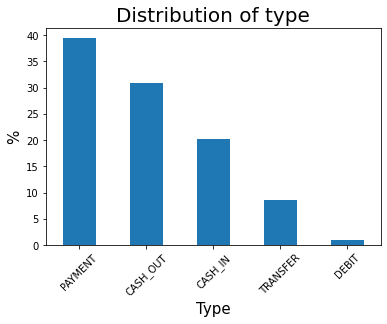

In [15]:
# Distribution of type

ax = (df["type"].value_counts(normalize=True)*100).plot(kind="bar", rot=45)
ax.set_title("Distribution of type", fontsize=20)
ax.set_xlabel("Type", fontsize=15)
ax.set_ylabel("%", fontsize=15)

The most common financial operations are payment, cash out and cash in, representing aournd 91% of all data.

In [16]:
# Distribution of isSamePerson

df["isSamePerson"].value_counts(normalize=True)*100

False    100.0
Name: isSamePerson, dtype: float64

Since 100% of the records are from different people, this feature engineering was not usefull and will not be used in our model as well as the percAmountOldOrig column.

Let's look for outliers by plotting the boxplot of each numerical feature.

Text(0.5, 1.0, 'Dest new balance distribution')

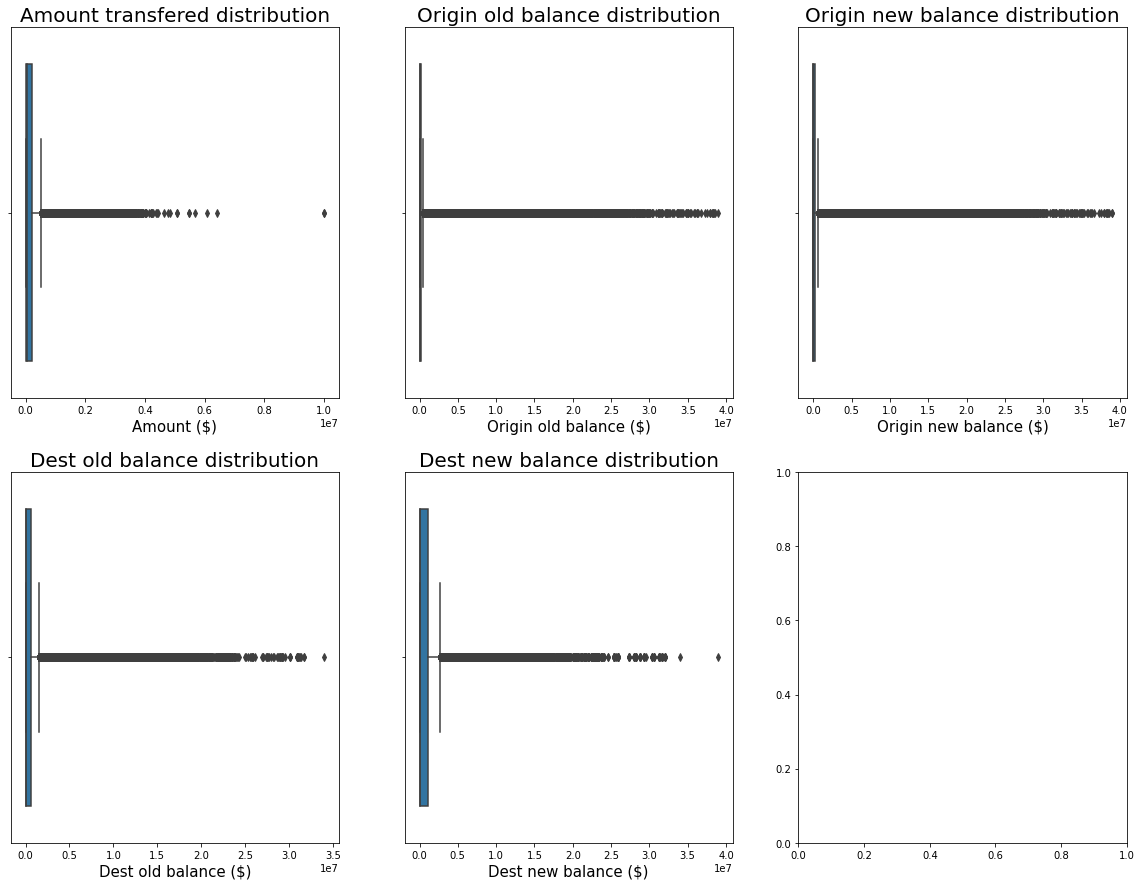

In [17]:
# Plotting several boxplots

fig, ((ax1, ax2, ax3), (ax4, ax5, _)) = plt.subplots(2,3, figsize = (20,15))

sns.boxplot(x = "amount", data=df, ax=ax1)
ax1.set_xlabel("Amount ($)", fontsize=15)
ax1.set_title("Amount transfered distribution", fontsize=20)

sns.boxplot(x = "oldbalanceOrig", data=df, ax=ax2)
ax2.set_xlabel("Origin old balance ($)", fontsize=15)
ax2.set_title("Origin old balance distribution", fontsize=20)

sns.boxplot(x = "newbalanceOrig", data=df, ax=ax3)
ax3.set_xlabel("Origin new balance ($)", fontsize=15)
ax3.set_title("Origin new balance distribution", fontsize=20)

sns.boxplot(x = "oldbalanceDest", data=df, ax=ax4)
ax4.set_xlabel("Dest old balance ($)", fontsize=15)
ax4.set_title("Dest old balance distribution", fontsize=20)

sns.boxplot(x = "newbalanceDest", data=df, ax=ax5)
ax5.set_xlabel("Dest new balance ($)", fontsize=15)
ax5.set_title("Dest new balance distribution", fontsize=20)

There are A LOT of values above 1.5 interquartile range, but just a few of them seems way higher. It is hard to see the other quartiles. Let's select amount transfered below $1000000 and look closely at these four outliers.

In [18]:
# Selecting the outliers

df_outlier = df[(df["amount"]> 8000000) | (df["newbalanceDest"]>33000000) | (df["oldbalanceDest"]>33000000)]

Text(0.5, 1.0, 'Dest new balance distribution')

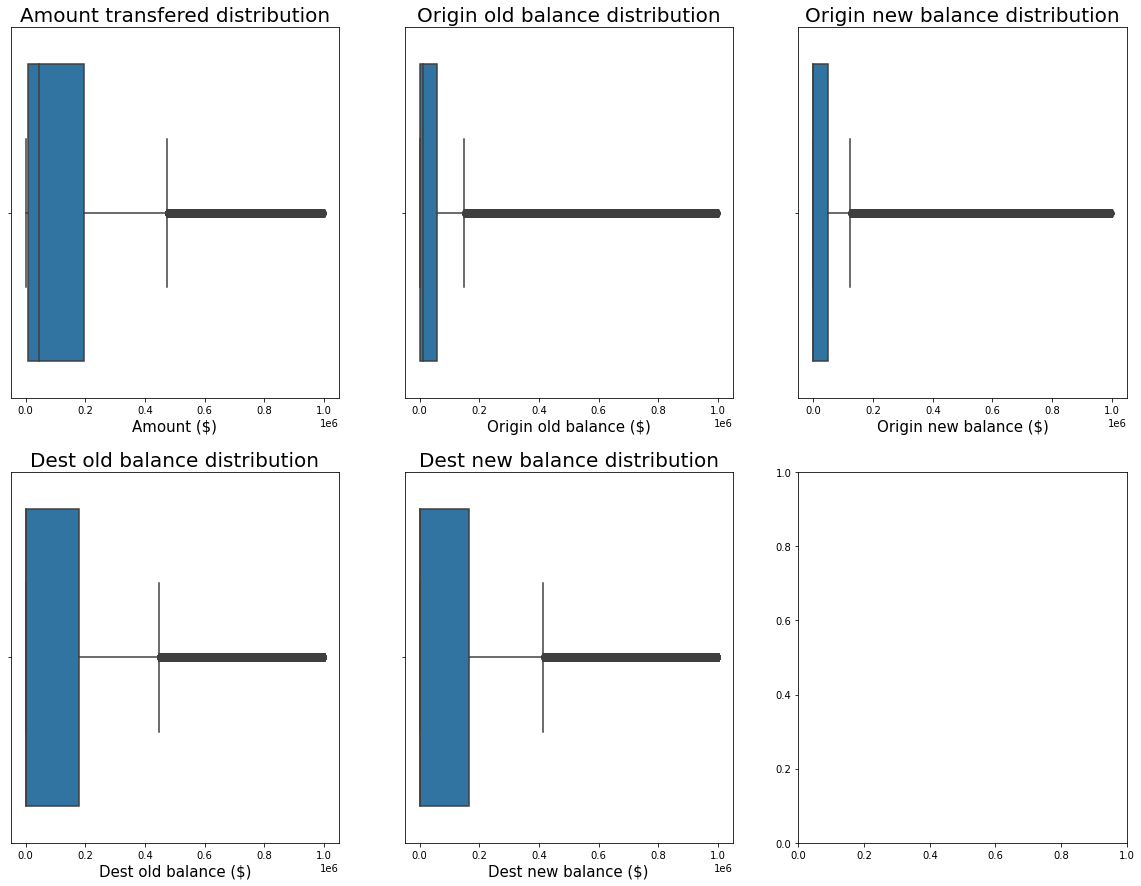

In [19]:
# Plotting several boxplots

fig, ((ax1, ax2, ax3), (ax4, ax5, _)) = plt.subplots(2,3, figsize = (20,15))

sns.boxplot(x = "amount", data=df[df["amount"]<1000000], ax=ax1)
ax1.set_xlabel("Amount ($)", fontsize=15)
ax1.set_title("Amount transfered distribution", fontsize=20)

sns.boxplot(x = "oldbalanceOrig", data=df[df["oldbalanceOrig"]<1000000], ax=ax2)
ax2.set_xlabel("Origin old balance ($)", fontsize=15)
ax2.set_title("Origin old balance distribution", fontsize=20)

sns.boxplot(x = "newbalanceOrig", data=df[df["newbalanceOrig"]<1000000], ax=ax3)
ax3.set_xlabel("Origin new balance ($)", fontsize=15)
ax3.set_title("Origin new balance distribution", fontsize=20)

sns.boxplot(x = "oldbalanceDest", data=df[df["oldbalanceDest"]<1000000], ax=ax4)
ax4.set_xlabel("Dest old balance ($)", fontsize=15)
ax4.set_title("Dest old balance distribution", fontsize=20)

sns.boxplot(x = "newbalanceDest", data=df[df["newbalanceDest"]<1000000], ax=ax5)
ax5.set_xlabel("Dest new balance ($)", fontsize=15)
ax5.set_title("Dest new balance distribution", fontsize=20)

In [20]:
# Displaying the outliers

df_outlier

step      type       amount     nameOrig  oldbalanceOrig  \
4440      4  TRANSFER  10000000.00     C7162498     12930418.44   
4441      4  CASH_OUT  10000000.00   C351297720     10000000.00   
90767    10   CASH_IN     36399.74  C1695613257        42140.00   
97729    10  TRANSFER   3749893.10   C267588521          647.00   

       newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
4440       2930418.44   C945327594            0.00            0.00        1   
4441             0.00   C766681183            0.00      9941904.21        1   
90767        78539.74  C1620573488     34008736.98     33972337.24        0   
97729            0.00  C1854925027        54183.46     38946233.02        0   

       percAmountOldOrig  isSamePerson  
4440           77.337018         False  
4441          100.000000         False  
90767          86.378121         False  
97729      579581.622875         False

We can see that the origin balances have half of the destination ones. This happens due to, probably, bills payments since the company's balance commonly will be higher than the normal person.

Looking at the outliers' df, all of them were labeled as non fraudulent transactions. So, all these records could belong to a big company or a whelthy person. 

In [21]:
# Couting the number of each target class

df["isFraud"].value_counts(normalize=True)*100

0    99.885841
1     0.114159
Name: isFraud, dtype: float64

The target class is very unbalanced, thus special technique will be needed to avoid bias or wrong predictions in our models. I will talk about it later.

Another easy way to do EDA is using pandas profiling library. It shows us the main statistics and some graphs that help us analyze our data.

In [22]:
# Displaying pandas profiling

pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Encoding

The column type is an object. We need to convert it into a numerical one, using one-hot enconding. This technique will transform n variables into n binary columns, i.e., with 0's and 1's. 

In [23]:
# Enconding type column

df = pd.get_dummies(data=df, columns=['type'])
df.head()

step    amount     nameOrig  oldbalanceOrig  newbalanceOrig     nameDest  \
0     1   9839.64  C1231006815        170136.0       160296.36  M1979787155   
1     1   1864.28  C1666544295         21249.0        19384.72  M2044282225   
2     1    181.00  C1305486145           181.0            0.00   C553264065   
3     1    181.00   C840083671           181.0            0.00    C38997010   
4     1  11668.14  C2048537720         41554.0        29885.86  M1230701703   

   oldbalanceDest  newbalanceDest  isFraud  percAmountOldOrig  isSamePerson  \
0             0.0             0.0        0           5.783397         False   
1             0.0             0.0        0           8.773495         False   
2             0.0             0.0        1         100.000000         False   
3         21182.0             0.0        1         100.000000         False   
4             0.0             0.0        0          28.079463         False   

   type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0             0              0           0             1              0  
1             0              0           0             1              0  
2             0              0           0             0              1  
3             0              1           0             0              0  
4             0              0           0             1              0

### Correlation matrix

Correlation matrix is a great way to check for feature selection based on linear correlation among features. If two or more of them are highly correlated, then they do not bring new informations to help model to perform better, so we can discard them.

In [24]:
# Displaying correlation matrix

df.corr().style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)\
.highlight_null(null_color='#f1f1f1').set_precision(2)

C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  after removing the cwd from sys.path.


We can see high linear corerlation between two pair of features, "oldbalanceOrig" & "newbalanceOrig" and "oldbalanceDest" and "newbalanceDest". We can choose one of each and discard the other but I will remain with both.

## Models

Let's select the features for our models.

In [25]:
# Selecting model's features

df_reduc = df.drop(["isSamePerson", "percAmountOldOrig", "nameDest", "nameOrig"], axis = 1)

In [26]:
# Checking the selected features

df_reduc.head()

step    amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  \
0     1   9839.64        170136.0       160296.36             0.0   
1     1   1864.28         21249.0        19384.72             0.0   
2     1    181.00           181.0            0.00             0.0   
3     1    181.00           181.0            0.00         21182.0   
4     1  11668.14         41554.0        29885.86             0.0   

   newbalanceDest  isFraud  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
0             0.0        0             0              0           0   
1             0.0        0             0              0           0   
2             0.0        1             0              0           0   
3             0.0        1             0              1           0   
4             0.0        0             0              0           0   

   type_PAYMENT  type_TRANSFER  
0             1              0  
1             1              0  
2             0              1  
3             0              0  
4             1              0

### Data balancing

Let's recall that the data set is highly unbalanced and the few fraudulent transactions may end up in the training or test set only, which could negativily affect the model's score. We have two options to solve this problem: do the undersampling or the oversampling. The former limit our records to value of the class that have less values, i.e., in our case, reduce to 116 rows of non-fraudulent transactions plus the another 116 fraudulent ones. The latter do the oposite, it creates duplicate data to equalize the number of outcomes between the two classes and in this case, we do not lose information but it may suffer of overfitting, when the model have a high performance in the training set and do not go well dealing with unseen data. That's why we can use the SMOTE technique.

SMOTE stands for Synthetic Minority Oversampling Technique which uses K-nearest neighbors to create synthetic (not duplicated!) data based on the minority class records. We can equalize the two outcome classes with less risk of overfitting. But who does it work?

First, the algorithm set the minotrity class and then choose randomly one of them (**a**) and its k neighbors (default is 5). Next, the model pick one among the five (**b**) and then a line is draw between them and the synthetic samples are created along this line ($\overline{ab}$) .  

Now, let's balance the data set.

In [27]:
# Setting the seed

SEED = 42

In [28]:
# Instatiating SMOTE

smote = SMOTE(random_state=42)

In [29]:
# Split the data set into dependent and independent variables

x = df_reduc.drop('isFraud', axis=1)
y = df_reduc['isFraud']

In [30]:
# Resampling the data

X_resampled, y_resampled = smote.fit_resample(x,y)

In [31]:
# Creating a balanced df

df_balanced = pd.concat([y_resampled, X_resampled], axis=1)
df_balanced

isFraud  step         amount  oldbalanceOrig  newbalanceOrig  \
0             0     1    9839.640000   170136.000000       160296.36   
1             0     1    1864.280000    21249.000000        19384.72   
2             1     1     181.000000      181.000000            0.00   
3             1     1     181.000000      181.000000            0.00   
4             0     1   11668.140000    41554.000000        29885.86   
...         ...   ...            ...             ...             ...   
202989        1     5   17608.962863    17608.962863            0.00   
202990        1     7   12116.291013    12116.291013            0.00   
202991        1     1  231612.880715   231612.880715            0.00   
202992        1     9  547325.144758   547325.144758            0.00   
202993        1     4  159298.594420   159298.594420            0.00   

        oldbalanceDest  newbalanceDest  type_CASH_IN  type_CASH_OUT  \
0             0.000000        0.000000             0              0   
1             0.000000        0.000000             0              0   
2             0.000000        0.000000             0              0   
3         21182.000000        0.000000             0              1   
4             0.000000        0.000000             0              0   
...                ...             ...           ...            ...   
202989        0.000000        0.000000             0              0   
202990        0.000000        0.000000             0              0   
202991     1945.589357     9370.603471             0              0   
202992        0.000000        0.000000             0              0   
202993        0.000000        0.000000             0              0   

        type_DEBIT  type_PAYMENT  type_TRANSFER  
0                0             1              0  
1                0             1              0  
2                0             0              1  
3                0             0              0  
4                0             1              0  
...            ...           ...            ...  
202989           0             0              1  
202990           0             0              1  
202991           0             0              0  
202992           0             0              1  
202993           0             0              1  

[202994 rows x 12 columns]

In [32]:
# Checking if the outcome classes are the same

df_balanced["isFraud"].value_counts()

0    101497
1    101497
Name: isFraud, dtype: int64

### Logistic regression

Logistic regression uses the so-called sigmoid function: $\sigma$(x) = $\frac{1}{1+e^{-x}}$, in this case, we are working with multidimensional data so x $\equiv$ $\theta$$^{T}$X, where $\theta$ is the weight factors (in other words, the weight of each feature that contributes to the model, the higher the $\theta$, more important is that feature associated with this factor) and X will be our independent variables. The sigmoid function returns a number between 0 and 1, also called $\hat{y}$. This can be interpreted as the probability of the customer buying the gadget given its pieces of information (features), or mathematically speaking, P(Y=1|X). In every iteration, the algorithm will set $\theta$ randomly, calculate the sigmoid function, and compare the output $\hat{y}$ with y, and calculate the error. The sum of all errors is called the cost of the model, 
Cost = J($\theta$) = $\frac{1}{m}$$\sum_{i=1}^{m} y^{i}log(\hat{y}^{i}) + (1-y^{i})log(1-y^{i})$. The model will use gradient descent to find the next values for $\theta$ and the process start over again until it minimizes the cost of the model. 

In calculus, the gradient ($\mathbf{\nabla}$) is a multivariable derivate of a function, also called vector in a 3D function, and it gives the information of the slope and direction of the curve uphill. So we need to take the -$\mathbf{\nabla}$ to update our parameter. There are no more updates when it reaches the global minimum of the cost function, that is why we choose the log function for our cost function rather than the sigmoid function. The sigmoid function is not always easy to find the global minimum. 

Now, let's build the first model.

In [33]:
# Creating the dependent and independent variables

X = df_balanced.drop(["isFraud"], axis=1).values
y = (df_balanced["isFraud"]).values

In [34]:
# Splitting the data with test size of 0.25

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = SEED)

In [35]:
# Fitting and predicting

lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(X_train, y_train)
y_pred =lr.predict(X_test)

In [36]:
print_scores(y_test, y_pred)

Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


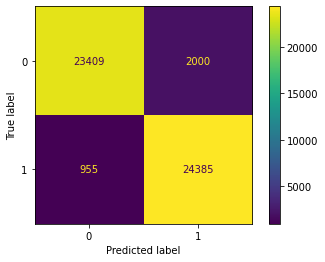

In [37]:
# Plotting the confusion matrix

%matplotlib inline

plot_confusion_matrix(y_test, y_pred)

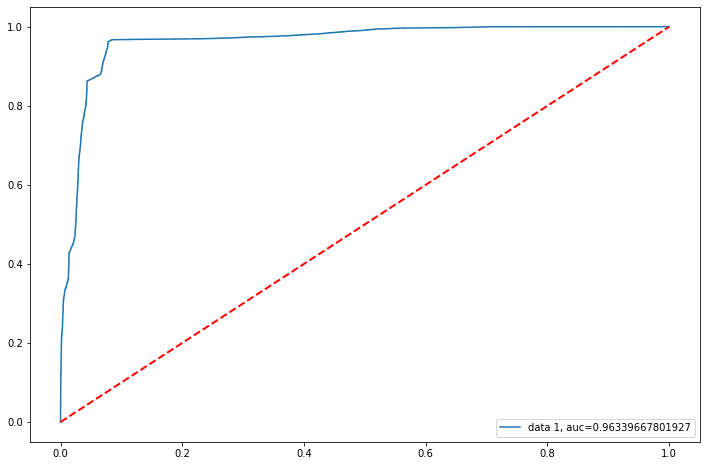

In [38]:
# Plotting ROC

y_pred_proba = lr.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plot_roc_auc(fpr, tpr, auc)

Before we interpret the scores, let's see what ROC and AUC are.

ROC stands for Receiver Operating Characteristic, which illustrates the diagnostic ability of a binary classifier system (0 or 1, True or False, Fraud or Non-fraud, etc.) as its discrimination threshold, false positive and true positive rates, is varied.
True positive rate (TPR) or sensitivity is given by TPR = $\frac{TP}{TP+FN}$ where TP is the true positives and FN is the false negatives. The false positive rate (FPR), or specificity, is defined by FPR = $\frac{FP}{FP+TN}$ where FP is the false positives and the TN is the true negatives. 

To build the ROC curve, the algorithm takes the predicted label outcomes and set several thresholds to classify 0 or 1 and then we calculate the TPR and FPR for all of them. The red dotted line is the area where TPR = FPR, that is, a bad classifier. The further the curve is away from this straight line the better. The perfect classifier model passes through (0,1).

AUC is the area under the ROC curve and it is possible to compare which curve (and model) is the best. The area varies between 0 and 1 and the closer to 1 the better. 

ROC and AUC summarize lots of confusion matrix information into one single metric, which is helpful when dealing with classification problems and threshold variation.

Now, let's evaluate the scores. They are high which means that they are good but there are some false positives and false negatives. A false positive means that the non-fraudulent transaction will be stopped and the client will call the bank to require it to continue it. A false negative implies more fraudulent transactions passing through our systems and this could lead to a loss of credibility and black flags from the gateway meaning loss of revenue. We must lower both numbers.

## Hipothesis

Before formulating a few hypotheses about the frauds, let's look at the profile report of df_balanced.

In [39]:
pandas_profiling.ProfileReport(df_balanced)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In the alerts tab, there are three features highly correlated with fraud: type_CASH_IN, type_PAYMENT and type_TRANSFER and looking at the correlation matrix, for these last two columns, the correlation is negative and positive respectively. Also, step (time) is highly negatively correlated. With all these in mind, it is possible to formulate few hipothesis. :

1. type_PAYMENT is the default payment method and the fraudulent transactions are made by type_TRANSFER;
2. people have a specific period of the day and of the month for payments and the fraud occurs outside these time windows, i.e., one usually pay the bills in the morning or in the beginning of the month and the fraud occurs at night or late days of the month. 

### Decision tree

Since we are dealing with a classification problem, let's start with the basics, training a decision tree model. Decision trees are tree-like algorithms with several leaves (or nodes) making decisions based on one feature of our dataset at a time creating two branches after each node. This process continues until the algorithm ends up with pure leaves, i.e. all the data in that node belongs to a single class. In the end, the algorithm creates a flowchart with all the decisions and features used in each node.

The algorithm selects the best feature for the nodes using some criteria such as the Gini index, log loss, entropy, and so on. For classification, the most used is Gini (G) which is given by:

$G = \sum_{k=1}^{k} p_{k}(1-p_{k})$, where k is the number of classes, $p_{k}$ is probability of one item into a node to belong  to a certain class k. On the other hand, the most common criteria for regression is the residual sum of squares (RSS) and it is given by:

$RSS = \sum_{i=1} (Y_{i}-\hat{Y_{i}})$, where $Y_{i}$ is the probability of an item to belong to a class and $\hat{Y_{i}}$ is the mean probability of all item in the node to belong to a class. In both cases, the algorithm will pick the feature that had the lower numbers first and do so in descending order until all the features are used once and only once or when the next feature increases the Gini index for the whole model. When one of these two scenarios happens, the "tree stops growing".

We can stop the algorithm from setting the minimum number of items into a leaf or limiting its depth because the deeper the tree gets the harder it is to interpret the model itself and the chances of overfitting increase. 

In [40]:
# Instatiating decision tree

tree =  DecisionTreeClassifier(max_depth = 5, random_state=SEED)

In [41]:
# Fitting and predicting

model = tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print_scores(y_test, y_pred)

Acurácia: 0.9622849711324362
Precisão: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943


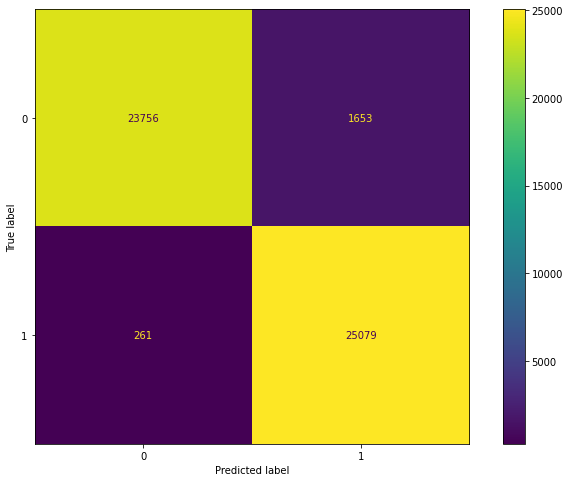

In [42]:
# Displaying confusion matrix

plot_confusion_matrix(y_test, y_pred)

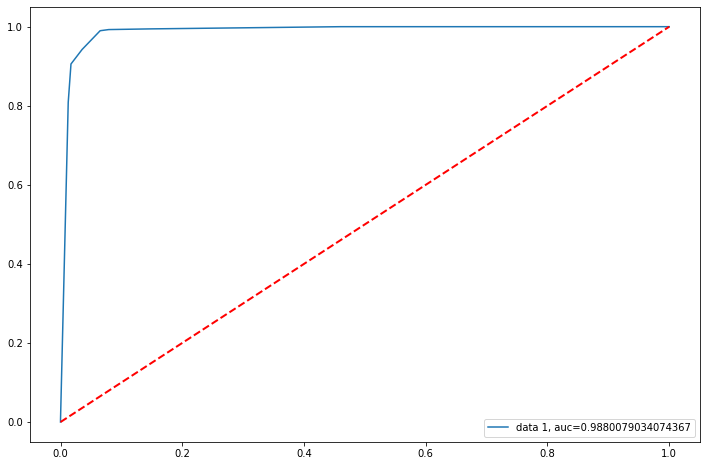

In [43]:
# Displaying ROC graph for AUC

y_pred_proba = tree.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plot_roc_auc(fpr, tpr, auc)

The decision tree performed better than logistic regression since the AUC increased. But we are facing the same problem as before, the number of false positives and false negatives are quite high and it is necessary lower them even more. Let's try ensemble learning to improve the scores.

## Random Forest

Random forest is a bagging ensemble learning technique. Bagging stands for *bootstrapping aggregating* which is a population resampling, in a way that the main characteristics are maintained and they have to be independent of each other. Then it will create a model using each of these subsamples and then aggregate all the outcomes in one metric (sum, mean, etc).

Randon forest creates several estimators, i.e. simple decision trees, using subsamples of the original data and some, not all, features to train the algorithm. Those records not used in a determined decision tree (out-of-bag data) will be labeled as True or False in this case. After all the algorithms are finished, the outcome of all records will be set as the most "voted" individual outcome of all algorithms. 

Now, let's build the random forest algorithm.

In [44]:
# Instatiating the model

rf = RandomForestClassifier(max_depth= 5, random_state = SEED)

In [45]:
# Fitting and predicting

model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print_scores(y_test, y_pred)

Acurácia: 0.9723738398786183
Precisão: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


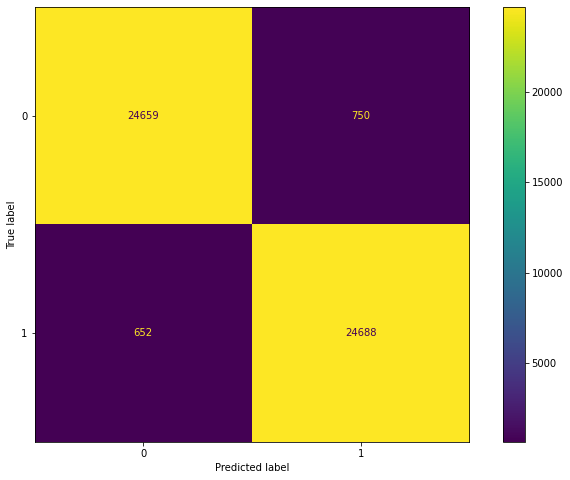

In [46]:
# Displaying confusion matrix

plot_confusion_matrix(y_test, y_pred)

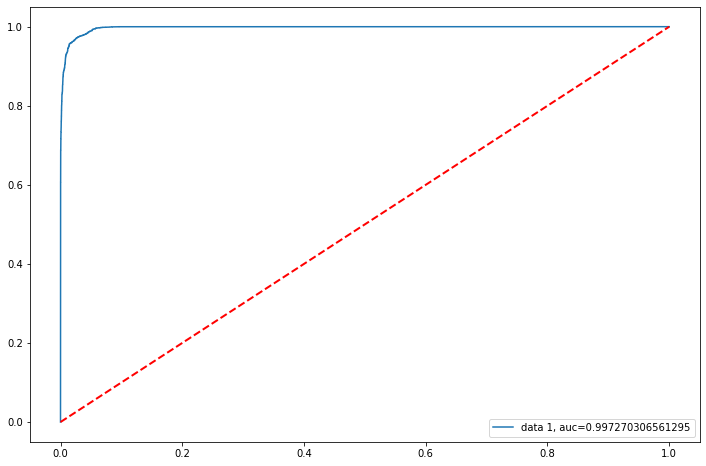

In [47]:
# Displaying ROC graph for AUC

y_pred_proba =  rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plot_roc_auc(fpr, tpr, auc)

The AUC increased again so did the number of false negatives. The random forest algorithm had around 600, compared to almost 300 in the decision tree model. It is possible to lower that number. For that, we will perform hyperparameter boosting using RandomizedSearchCV.

## Hyperparameter boosting with RandomizedSearchCV

RandomizedSearchCV takes a metric, a model, and several different parameters and chooses the best one based on the most important metric in each case. The algorithm will run every model with every possible hyperparameter combination possible and will select and display what are the best parameters and their metric value. 

In [48]:
SEED2 = 70

In [49]:
# Setting the parameters

n_estimators = np.arange(20, 200, step=20)
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(2, 10, step=1))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [50]:
# Dict with all the parameters

param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}


In [51]:
# Instatiating the random forest

rforest = RandomForestClassifier(random_state=SEED2)

In [52]:
# Running the randomized search

random_cv = RandomizedSearchCV(
    rforest, param_grid, n_iter=5, cv=3, scoring="recall", n_jobs=-1, random_state = SEED2
)


In [53]:
# Fitting the model

%time
rcv = random_cv.fit(X, y)

Wall time: 0 ns


In [54]:
# Creating a df with randomized search

pd.DataFrame(rcv.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      54.945743      3.194042         1.487180        0.069318   
1      17.494598      0.198211         1.143998        0.034321   
2      22.167612      3.555651         0.562004        0.143088   
3      45.187437      1.922854         0.918410        0.123132   
4      24.734116      4.458926         0.955658        0.290952   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                120                       4                      2   
1                120                       4                      2   
2                 40                       8                      1   
3                100                       8                      4   
4                160                       6                      2   

  param_max_features param_max_depth param_criterion param_bootstrap  \
0               auto               9            gini           False   
1               auto               2            gini           False   
2               sqrt               7         entropy           False   
3               log2               9         entropy            True   
4               log2               2            gini           False   

                                              params  split0_test_score  \
0  {'n_estimators': 120, 'min_samples_split': 4, ...           0.991665   
1  {'n_estimators': 120, 'min_samples_split': 4, ...           0.914223   
2  {'n_estimators': 40, 'min_samples_split': 8, '...           0.980285   
3  {'n_estimators': 100, 'min_samples_split': 8, ...           0.993497   
4  {'n_estimators': 160, 'min_samples_split': 6, ...           0.914223   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.999438           0.992817         0.994640        0.003425   
1           0.936009           0.862704         0.904312        0.030736   
2           1.000000           0.973812         0.984699        0.011138   
3           0.999025           0.992226         0.994916        0.002951   
4           0.943487           0.876537         0.911416        0.027404   

   rank_test_score  
0                2  
1                5  
2                3  
3                1  
4                4

In [55]:
# Printing the best parameters

rcv.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 9,
 'criterion': 'entropy',
 'bootstrap': True}

Here we can see what are the best parameters for the random forest. Let's plug these into our final model. 

## Final model

In [56]:
# Building the final model

final_rf = RandomForestClassifier(**rcv.best_params_, random_state = SEED2)

model = final_rf.fit(X_train, y_train)
y_pred = final_rf.predict(X_test)

In [57]:
# Printing final model scores

print_scores(y_test, y_pred)

Acurácia: 0.9915860411042582
Precisão: 0.9906258615936036
Recall: 0.9925414364640884
F1: 0.9915827238857459


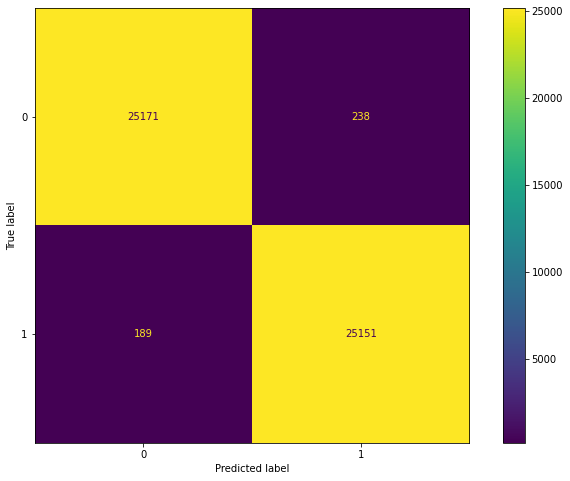

In [58]:
# Plotting the confusion matrix for the final model

plot_confusion_matrix(y_test, y_pred)

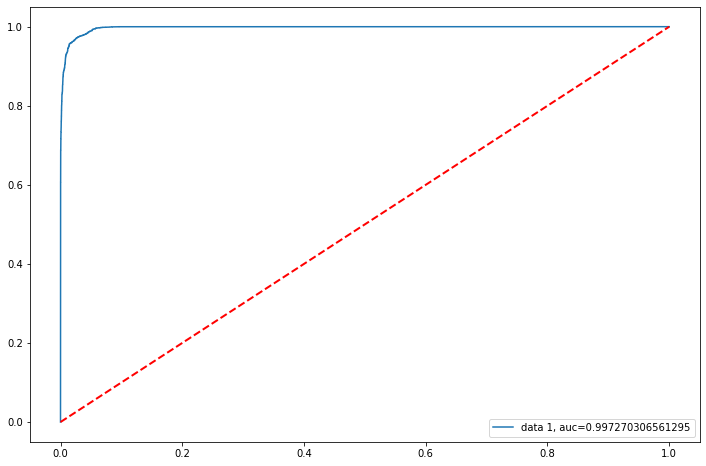

In [59]:
# Displaying ROC graph for AUC

plot_roc_auc(fpr, tpr, auc)

Indeed, we have got the best AUC of all models: 0.99957797.

## Recomendations

We can draw some recomendations based on the hipothesis formulated before:

1. Build a CAPTCHA-like system for suspicious transactions out of most common time windows for each costumer;
2. Add security questions when the customer is using a different type of transaction.